## Project 3 - ML Approach to Terrain Slope Failure 🌲🌲🌲
- `P(slope Failure) = RF(terrain, lithology/soils, distance)`

In [202]:
#import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as SPLIT
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [128]:
df = pd.read_csv('./Project3Data/lsm_data2.csv') #Read Data
df.head(2)

,class,slp,sp21,sp11,sp7,rph21,rph11,rph7,diss21,diss11,...,state_dist,local_dist,strm_dist,strm_cost,us_cost,state_cost,local_cost,steve,dspm,drain
0,not,4.85612,-2.560850,-0.799744,-0.338257,18.655701,2.11668,0.248973,0.042033,0.056310,...,6168.839844,0.000000,72.801102,86.637901,2239.270020,14990.799800,65.587799,4,1,1
1,not,4.91437,-0.353561,-0.027847,0.018600,4.788600,1.27792,0.473525,0.392066,0.421253,...,3517.290039,421.070007,534.603027,1660.099976,3253.659912,2088.399902,1857.839966,5,5,2


### Encode Class Variable
```python 
{'not':0, 'slopeD':1} 
```

In [129]:
encode_map = {'not':0, 'slopeD':1} 
df['class'] = df['class'].map(encode_map) #Map Column to Integer Values

In [130]:
df_ls = [df.iloc[:,1:], df.iloc[:,1:32], df.iloc[:,41:], df.iloc[:,33:41], df.iloc[:,33:]]
df_labels =['ALL', 'Terrain', 'Lithology/Soils', 'Distance', 'All Not Terrain'] #Hold Set Features

## Fit Random Forest Model Across Spatial Features
> _**Optimize Slope Failure (Class 1) Predictions**_

In [210]:
rates, models = [], [] #2-d array holding fpr + tpr vals & 1-d array storing RF models
for idx in range(len(df_ls)):
    print('\033[30;1mAnalysis of {} Features'.format(df_labels[idx]))
    #Split and Stratify Data
    x_train, x_test, y_train, y_test = SPLIT(df_ls[idx], df.iloc[:,0], test_size=.333, stratify=df.iloc[:,0],
                                            random_state=0)
    #Fit Model
    rf = RandomForestClassifier(n_estimators=120, max_depth=5, min_samples_leaf=8)
    rf.fit(x_train, y_train)
    models.append(rf) #save model
    
    #Confusion Matrix
    print('\033[96mConfusion Matrix:\n', pd.DataFrame(confusion_matrix(y_test, rf.predict(x_test))).\
          rename(columns={0:'Pred_NonFailure', 1:'Pred_Failure'},
                                                    index={0:'True_NonFailure', 1:'True_Failure'}), '\n')
    #Classification Report
    print('Classification Report:\n', classification_report(y_test, rf.predict(x_test), 
                                                         target_names=['Non-Failure', 'SlopeFailure']),'\n')
    
    #ROC + AUC Metric
    fpr, tpr, thres = roc_curve(y_test, rf.predict_proba(x_test)[:,1])
    rates.append([fpr, tpr])
    print('AUC:', auc(fpr, tpr))
    
    #Calc optimized p(y) thres vlalue
    optimal_threshold = thres[np.argmax(tpr - fpr)] 
    print(f"Optimal P(Y) Threshold: {round(optimal_threshold,3)}", '\n____________________________________\n')

Analysis of ALL Features
Confusion Matrix:
                  Pred_NonFailure  Pred_Failure
True_NonFailure              468           115
True_Failure                  66           517 

Classification Report:
               precision    recall  f1-score   support

 Non-Failure       0.88      0.80      0.84       583
SlopeFailure       0.82      0.89      0.85       583

    accuracy                           0.84      1166
   macro avg       0.85      0.84      0.84      1166
weighted avg       0.85      0.84      0.84      1166
 

AUC: 0.9261788407391827
Optimal P(Y) Threshold: 0.541 
____________________________________

Analysis of Terrain Features
Confusion Matrix:
                  Pred_NonFailure  Pred_Failure
True_NonFailure              470           113
True_Failure                  63           520 

Classification Report:
               precision    recall  f1-score   support

 Non-Failure       0.88      0.81      0.84       583
SlopeFailure       0.82      0.89      0.86

### ROC Curves

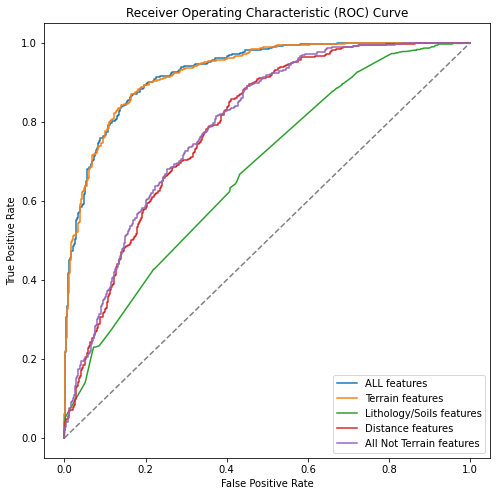

In [85]:
#ROC curve

plt.figure(figsize=(8, 8))

for idx in range(len(rates)):
    plt.plot(rates[idx][0], rates[idx][1], label=df_labels[idx]+' features')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


## Task 8
> The models incorporating all features and terrain features perform the best on basis of overall accuracy
and percision in predicting the positive class (slope failure). An optimized probability cutoff threshold value
is also  provided in analysis in order to program a model optimizing the true positive and false positive 
cutoff. The terrain model should be leveraged in order to predict the positive class due to it's robustness of 
predicting slope failure and it's use of less variables to minimize computaion time. 
Other models incorporating different spatial features perform generally well however do not contain the 
same level of strength in overall prediction but primarily for the positive class (slope failure) that we
are interested in estimating. Confusion matrixes were developed to view counts of predictions against actual
values to determine the strength of predictions for the binary classes and imbalances in predictions.
The ROC curve allows a visual of the trade-off between TP and FP rates at different probability cutoff values. The AUC metric provides insight into the capability of the model to 
distinguish between the positve & negative class in predictions, the higher value conveys a wider region
under the ROC curve detailing a model efficient in predictions of both classes. 

### Apply on Pixelated LiDar Imagery 📡
- `43 Spectral Bands`
- _Shape_: `(954,1170)`

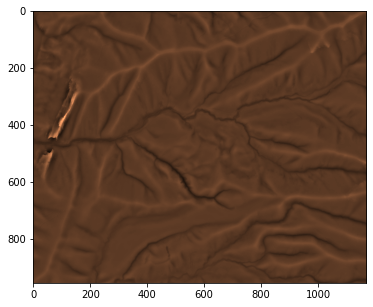

In [197]:
import rasterio
from rasterio.plot import show

plt.figure(figsize=(10,5))
rstr_data = []
img_path= "./Project3Data/stack2.img"
with rasterio.open(img_path) as src:
    slp_band = src.read(1) #View Raster
    show(slp_band, cmap='copper')
    
    for idx in range(1,44):
        rstr_data.append(src.read(idx).flatten())

# plot pixel band
plt.show()


In [162]:
np.array(rstr_data).shape #Shape of extrapolated pixel data

(43, 1116180)

In [139]:
y_pred = models[0].predict(np.array(rstr_data).T) #Perform Predictions

In [151]:
class_, cnt = np.unique(y_pred, return_counts=True)  
[print(val, ': ', count, ' predictions', sep='') for val, count in zip(class_, cnt)][0]

0: 1034000 predictions
1: 82180 predictions
